<a href="https://colab.research.google.com/github/asloth/NN_Emtion_Recognition/blob/main/NN_EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import keras

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

In [114]:
go_train_data = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/data/train.tsv", sep='\t', header=None, usecols=[0,1], names=["Text","Emotion_index"], encoding="utf-8")
go_test_data = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/data/test.tsv",  sep='\t', header=None, usecols=[0,1], names=["Text","Emotion_index"], encoding="utf-8")

In [115]:
print("Train : ", go_train_data.shape)
print("Test : ", go_test_data.shape)

Train :  (43410, 2)
Test :  (5427, 2)


In [206]:
test_data = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/data/archive/test.txt", header=None, sep=";", names=["Text","Emotion"], encoding="utf-8")
train_data = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/data/archive/train.txt", header=None, sep=";", names=["Text","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/data/archive/val.txt", header=None, sep=";", names=["Text","Emotion"], encoding="utf-8")

In [195]:
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


#Explorar la data

In [196]:
test_data.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [197]:
train_data.describe(include='O')

,Text,Emotion
count,16000,16000
unique,15969,6
top,i feel a remembrance of the strange by justin ...,joy
freq,2,5362


In [201]:
test_data['Emotion'].unique()

array(['sadness', 'joy', 'fear', 'anger', 'love', 'surprise'],
      dtype=object)

In [199]:
test_data.describe(include='O')

,Text,Emotion
count,2000,2000
unique,2000,6
top,i was feeling more and more frustrated with ea...,joy
freq,1,695


[]

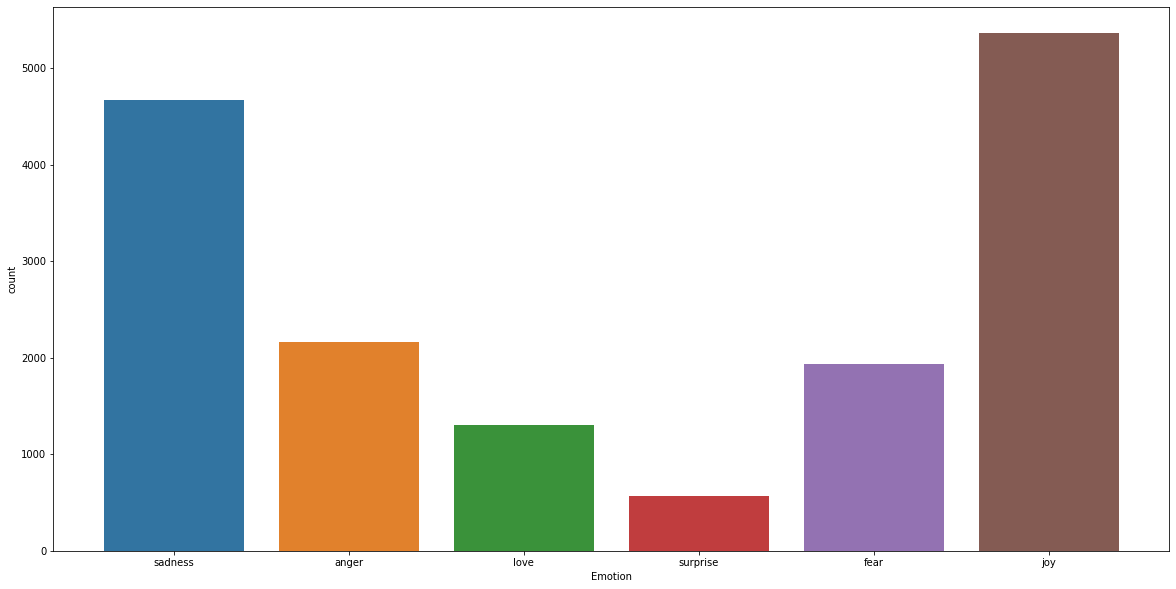

In [9]:
plt.figure(figsize=(20,10))
sns.countplot(x='Emotion' , data=train_data)
plt.plot()

In [190]:
train_data['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

In [193]:
test_data['Emotion'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64

[]

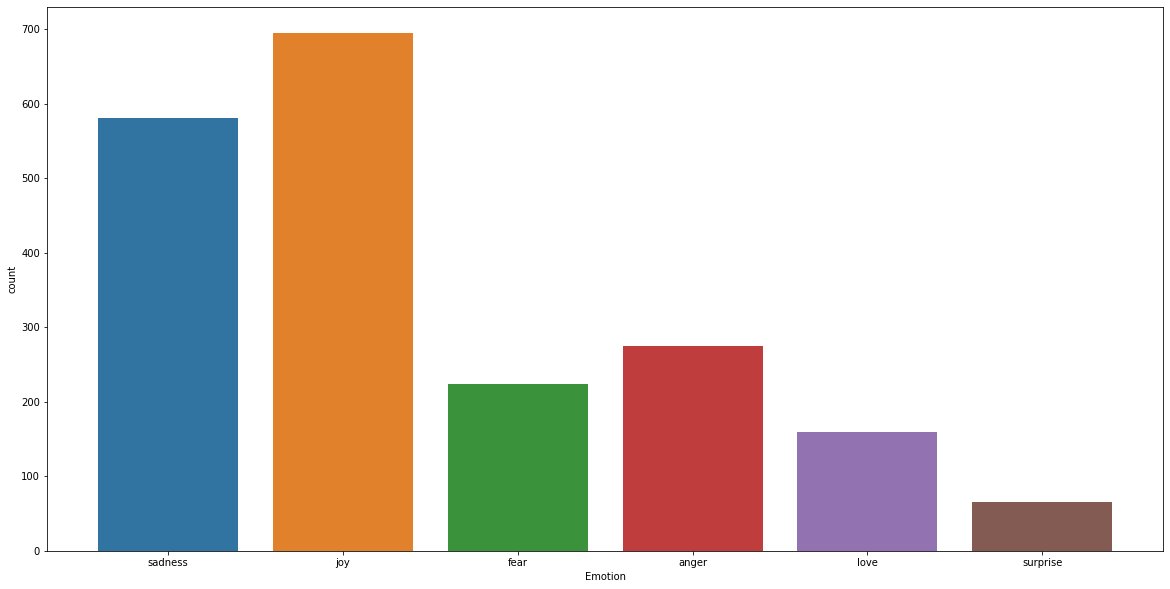

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(x='Emotion' , data=test_data)
plt.plot()

#Preprocesar el texto

In [118]:
#go emotions
def grouping_go_data(data):
  data = data.drop('Emotion_index', axis=1).join(data['Emotion_index'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Emotion_index'))
  data['Emotion'] = data['Emotion_index'].map({
      '0':'admiration',
      '1':'amusement',
      '2':'anger',
      '3':'annoyance',
      '4':'approval',
      '5':'caring',
      '6':'confusion',
      '7':'curiosity',
      '8':'desire',
      '9':'disappointment',
      '10':'disapproval',
      '11':'disgust',
      '12':'embarrassment',
      '13':'excitement',
      '14':'fear',
      '15':'gratitude',
      '16':'grief',
      '17':'joy',
      '18':'love',
      '19':'nervousness',
      '20':'optimism',
      '21':'pride',
      '22':'realization',
      '23':'relief',
      '24':'remorse',
      '25':'sadness',
      '26':'surprise',
      '27':'neutral'
  })
  #juntando emociones
  data['Emotion']= data['Emotion'].replace(['annoyance', 'disapproval'], 'anger')
  data['Emotion']= data['Emotion'].replace(['nervousness'], 'fear')
  data['Emotion']= data['Emotion'].replace(["amusement", "approval", "excitement", "gratitude",  "optimism", "relief", "pride", "admiration", "desire", "caring"], "joy")
  data['Emotion']= data['Emotion'].replace(["disappointment", "embarrassment", "grief",  "remorse"], "sadness")
  data['Emotion']= data['Emotion'].replace(["realization", "confusion", "curiosity"], "surprise")
  return data


In [119]:
go_train_data = grouping_go_data(go_train_data)
go_test_data = grouping_go_data(go_test_data)

[]

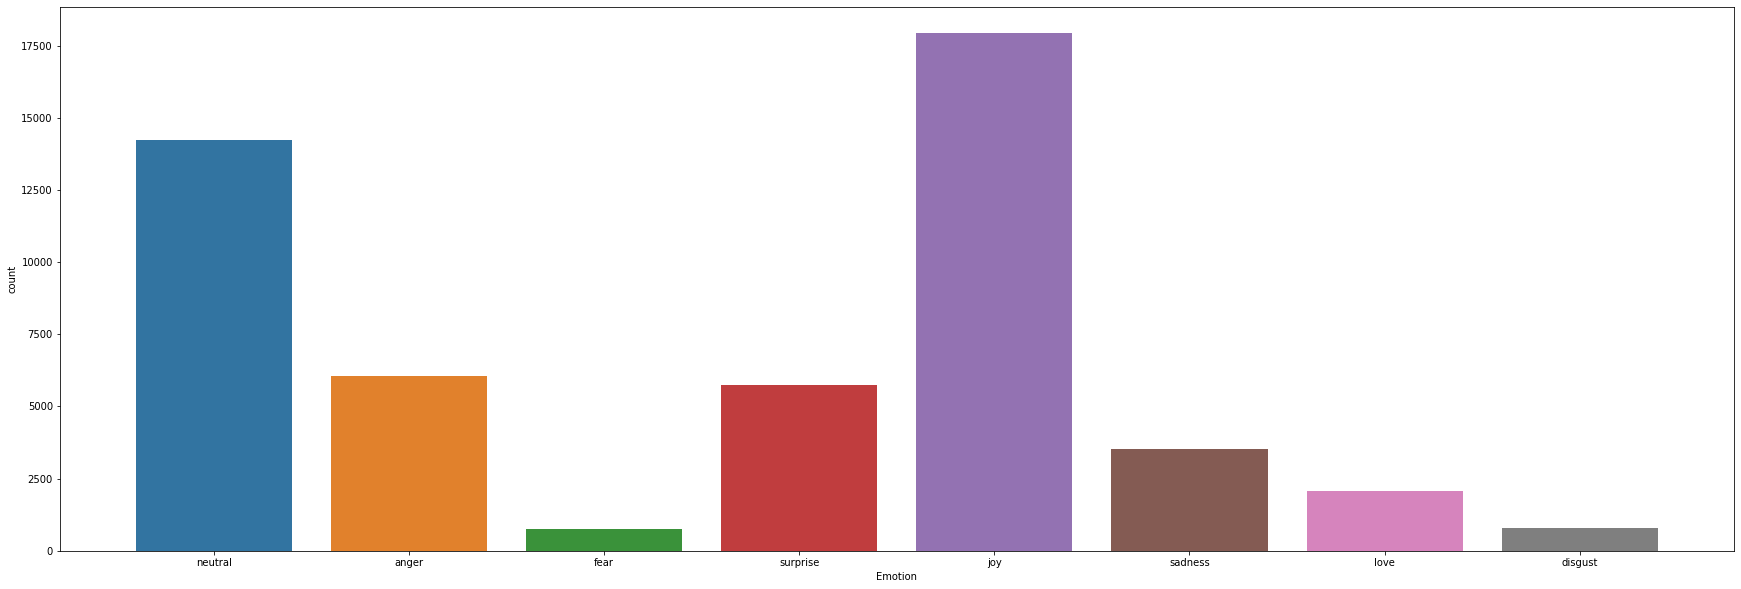

In [14]:
plt.figure(figsize=(30,10))
sns.countplot(x='Emotion' , data=go_train_data)
plt.plot()

[]

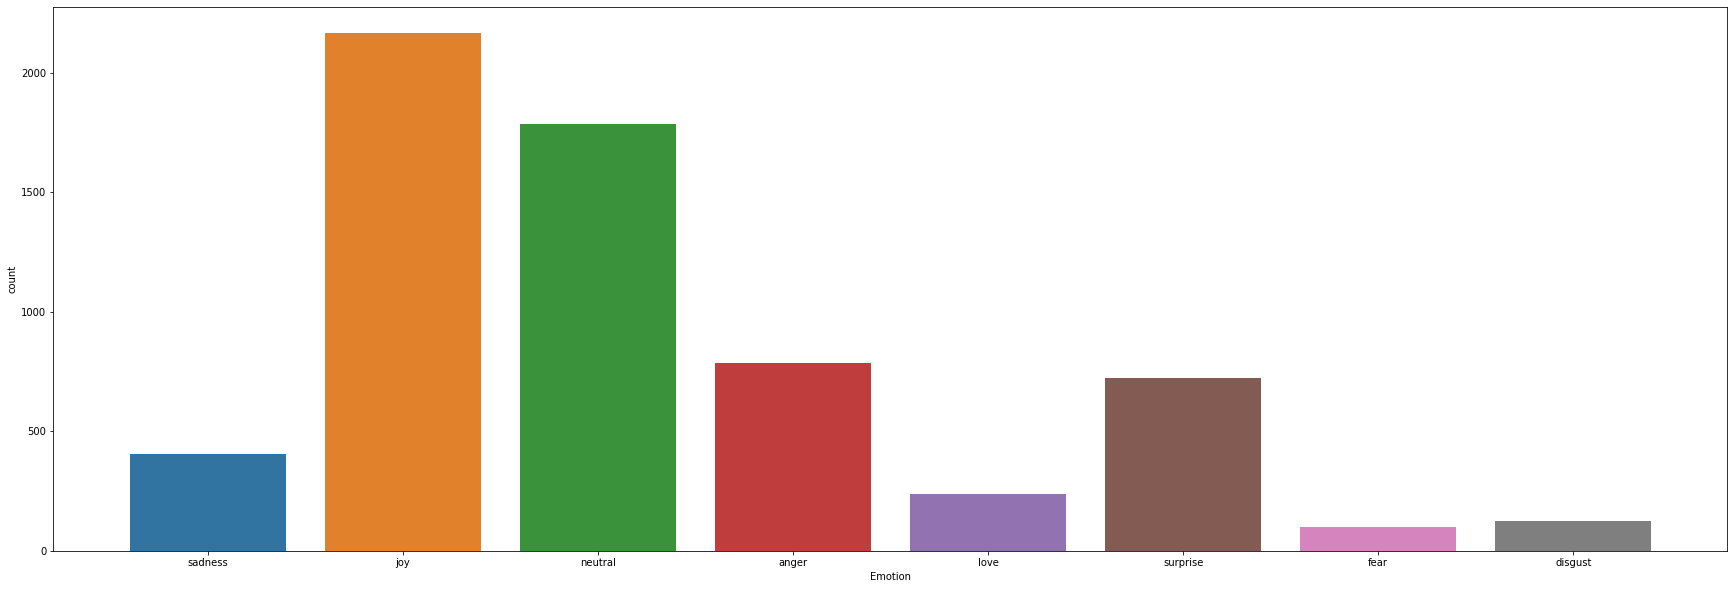

In [15]:
plt.figure(figsize=(30,10))
sns.countplot(x='Emotion' , data=go_test_data)
plt.plot()

In [120]:
surprise_data = go_train_data[go_train_data['Emotion'] =='surprise']
love_data = go_train_data[go_train_data['Emotion'] =='love']
fear_data = go_train_data[go_train_data['Emotion'] =='fear']
anger_data = go_train_data[go_train_data['Emotion'] =='anger']
sadness_data = go_train_data[go_train_data['Emotion'] =='sadness']

In [121]:
anger_data = anger_data[:3000]
sadness_data = sadness_data[:1000]
surprise_data = surprise_data[:4000]

In [122]:
new_train_data = pd.concat([train_data,love_data[['Text','Emotion']] ])
new_train_data = pd.concat([new_train_data,surprise_data[['Text','Emotion']] ])
new_train_data = pd.concat([new_train_data,fear_data[['Text','Emotion']] ])
new_train_data = pd.concat([new_train_data,anger_data[['Text','Emotion']] ])
new_train_data = pd.concat([new_train_data,sadness_data[['Text','Emotion']] ])
new_train_data.reset_index(inplace=True)
new_train_data

,index,Text,Emotion
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger
...,...,...,...
26841,12057,In my few years playing I never knew this ... ...,sadness
26842,12060,I saw your missing post and hoped you found yo...,sadness
26843,12062,"You're clearly upset tho, you're not doing a g...",sadness
26844,12074,I’m sorry to hear this. Live a hell of a life ...,sadness


[]

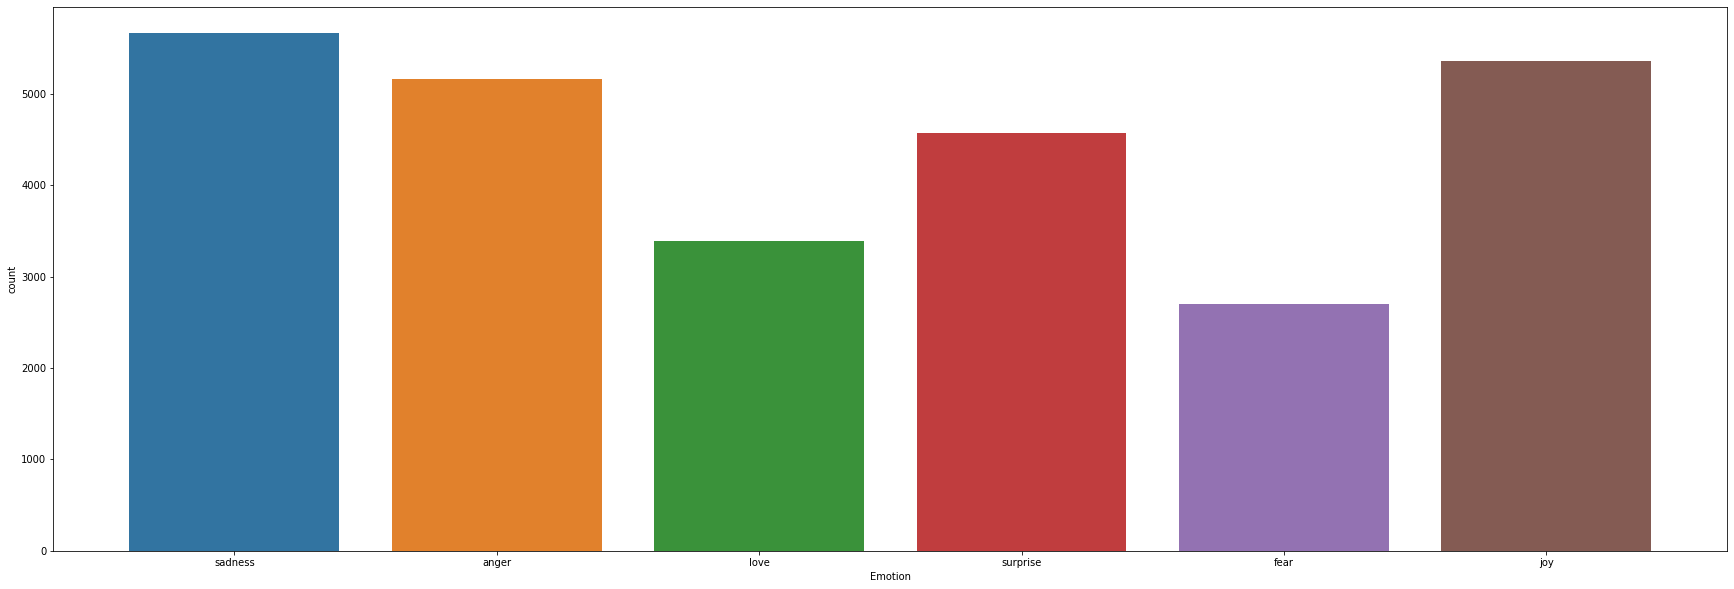

In [38]:
plt.figure(figsize=(30,10))
sns.countplot(x='Emotion' , data=new_train_data)
plt.plot()

In [123]:
surprise_test_data = go_test_data[go_test_data['Emotion'] =='surprise']
love_test_data = go_test_data[go_test_data['Emotion'] =='love']
fear_test_data = go_test_data[go_test_data['Emotion'] =='fear']
anger_test_data = go_test_data[go_test_data['Emotion'] =='anger']
sadness_test_data = go_test_data[go_test_data['Emotion'] =='sadness']

In [44]:
sadness_test_data.shape

(406, 3)

In [124]:
anger_test_data = anger_test_data[:500]
sadness_test_data = sadness_test_data[:200]

In [125]:
new_test_data = pd.concat([test_data,surprise_test_data[['Text','Emotion']] ])
new_test_data = pd.concat([new_test_data,love_test_data[['Text','Emotion']] ])
new_test_data = pd.concat([new_test_data,fear_test_data[['Text','Emotion']] ])
new_test_data = pd.concat([new_test_data,anger_test_data[['Text','Emotion']] ])
new_test_data = pd.concat([new_test_data,sadness_test_data[['Text','Emotion']] ])
new_test_data.reset_index(inplace=True)
new_test_data

,index,Text,Emotion
0,0,im feeling rather rotten so im not very ambiti...,sadness
1,1,im updating my blog because i feel shitty,sadness
2,2,i never make her separate from me because i do...,sadness
3,3,i left with my bouquet of red and yellow tulip...,joy
4,4,i was feeling a little vain when i did this one,sadness
...,...,...,...
3757,2845,This is some of the worst passing I've ever seen.,sadness
3758,2853,Can’t believe [NAME] era is coming to an end.....,sadness
3759,2884,I mean yeah we were the best counter attacking...,sadness
3760,2885,There are Cubs fans that died at 95 without ev...,sadness


[]

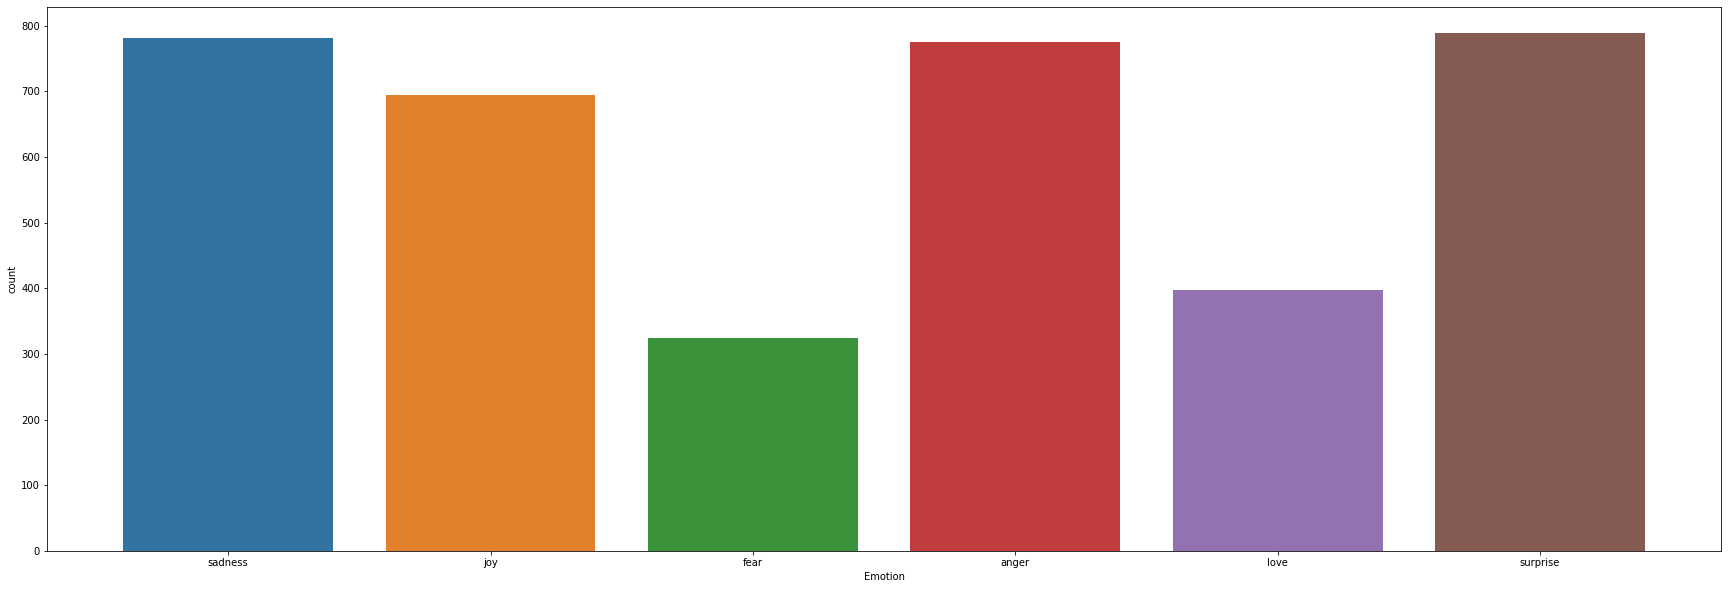

In [50]:
plt.figure(figsize=(30,10))
sns.countplot(x='Emotion' , data=new_test_data)
plt.plot()

##Cleaning

###Data x

In [180]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [181]:
sw = stopwords.words('english')

In [128]:
vocab_size = 10000
len_sentence = 150

In [129]:
def text_prepare(data, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        
        text = text.lower()
        text = text.split()
        
        text = [stemmer.stem(word) for word in text if word not in sw]
        text = " ".join(text)
        
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    embeddec_doc = pad_sequences(sequences=one_hot_word, maxlen=len_sentence, padding="pre")
    return embeddec_doc

In [130]:
x_train=text_prepare(train_data, "Text")
x_validate=text_prepare(validation_data, "Text")
x_test=text_prepare(test_data, "Text")

In [207]:
tokenizer = Tokenizer()

def text_tokenize(tokenizer, data , column):
  corpus = []
  for text in data[column]:
      text = re.sub("[^a-zA-Z]", " ", text)
      text = text.lower()
      text = text.split()
      text = " ".join(text)
      corpus.append(text)
  tokenizer.fit_on_texts(corpus)
  sequences = tokenizer.texts_to_sequences(data[column])
  return pad_sequences(sequences, maxlen=256, truncating='pre')

In [208]:
x_train=text_tokenize(tokenizer,train_data, "Text")
x_test=text_tokenize(tokenizer,test_data, "Text")
x_validate=text_tokenize(tokenizer,validation_data, "Text")

In [209]:
print(y_train.shape)
print(x_train.shape)

(16000, 6)
(16000, 256)


In [215]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17097

###Data Y

In [202]:
y_train=train_data["Emotion"]
y_validate=validation_data["Emotion"]
y_test=test_data["Emotion"]

In [168]:
#ONE HOT ENCODER 
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

#los pasa a array
y_train = np.array(y_train)
y_test = np.array(y_test)
y_validate = np.array(y_validate)
#array(['sadness', 'sadness', 'anger', ..., 'joy', 'anger', 'sadness'],
      #dtype=object)

      #los pasa one hot encode
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()
y_validate = enc.fit_transform(y_validate.reshape(-1,1)).toarray()

In [203]:
#LABEL ENCODER
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_validate)
y_validate= le.fit_transform(y_validate)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_validate = to_categorical(y_validate)
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [213]:
y_train.shape

(16000, 6)

##GloVe

In [230]:
path_to_glove = '/content/drive/MyDrive/Universidad/Tesis/glove_6b/glove.6B.200d.txt'

embeddings_index = {}


file = open(path_to_glove, encoding='utf-8')
# Read word vectors
for line in file:
    word, coef = line.split(maxsplit=1)
    vectors = np.fromstring(coef, "f", sep=" ")
    embeddings_index[word] = vectors

file.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


In [231]:
embedding_dimension = 200

In [249]:
hits = 0
misses = 0

word_vector_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in tokenizer.word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        word_vector_matrix[i] = vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15878 words (1218 misses)


#Modelo

In [234]:
len_sentence

150

In [245]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=x_train.shape[1], weights=[word_vector_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

#model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=x_train.shape[1],  weights=[word_vector_matrix], trainable=False))
#model.add(Dropout(0.2))
#model.add(LSTM(128))
#model.add(Dropout(0.2))
#model.add(Dense(64, activation="sigmoid"))
#model.add(Dropout(0.2))
#model.add(Dense(6, activation="softmax"))
model.compile(optimizer=adam, loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 200)          3419400   
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 512)          935936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256, 256)          656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 1542      
Total params: 5,407,502
Trainable params: 1,988,102
Non-trainable params: 3,419,400
_________________________________________________________________


In [247]:
# mode = 'min',
es = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 2, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/Universidad/Tesis/model_v6_glove.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [241]:
x_train.dtype
x_train.shape

(16000, 256)

In [242]:
y_train.dtype
y_train.shape

(16000, 6)

In [248]:
hist = model.fit(x_train, y_train, epochs = 10, batch_size = 256, validation_data=(x_test, y_test),verbose = 1, callbacks= [es])

Epoch 1/10
63/63 [==============================] - 2289s 36s/step - loss: 1.5945 - accuracy: 0.3314 - val_loss: 1.5852 - val_accuracy: 0.3345

Epoch 00001: val_accuracy improved from -inf to 0.33450, saving model to /content/drive/MyDrive/Universidad/Tesis/model_v6_glove.h5
Epoch 2/10
63/63 [==============================] - 2025s 32s/step - loss: 1.5781 - accuracy: 0.3407 - val_loss: 1.5874 - val_accuracy: 0.3225

Epoch 00002: val_accuracy did not improve from 0.33450
Epoch 3/10
63/63 [==============================] - 1986s 32s/step - loss: 1.5546 - accuracy: 0.3761 - val_loss: 1.6569 - val_accuracy: 0.3275
Restoring model weights from the end of the best epoch.

Epoch 00003: val_accuracy did not improve from 0.33450
Epoch 00003: early stopping


#Traer el modelo guardado

In [165]:
# Recrea exactamente el mismo modelo solo desde el archivo
model = keras.models.load_model('/content/drive/MyDrive/Universidad/Tesis/model_v3.h5')

#Performance metrics

In [169]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
59/59 [==============================] - 7s 105ms/step - loss: 3.5541 - accuracy: 0.2007
test loss, test acc: [3.5540859699249268, 0.2006911188364029]


In [68]:
from sklearn.metrics import confusion_matrix, classification_report

array([4, 4, 4, ..., 4, 4, 4])

In [170]:
y_test = np.argmax(y_test, axis=1)
y_test

array([4, 4, 4, ..., 4, 4, 4])

In [171]:
y_pred=model.predict(x_test) 
y_pred=np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 4, ..., 0, 0, 0])

In [172]:
label2int = {
  "sadness": 4,
  "joy": 2,
  "love":3,
  "anger": 0,
  "fear": 1,
  "surprise": 5
}

In [173]:
print('Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=label2int.keys()))

Confusion Matrix
              precision    recall  f1-score   support

     sadness       0.21      0.73      0.32       775
         joy       0.06      0.03      0.04       325
        love       0.21      0.06      0.10       695
       anger       0.12      0.00      0.00       397
        fear       0.21      0.17      0.19       781
    surprise       0.00      0.00      0.00       789

    accuracy                           0.20      3762
   macro avg       0.14      0.17      0.11      3762
weighted avg       0.14      0.20      0.13      3762



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

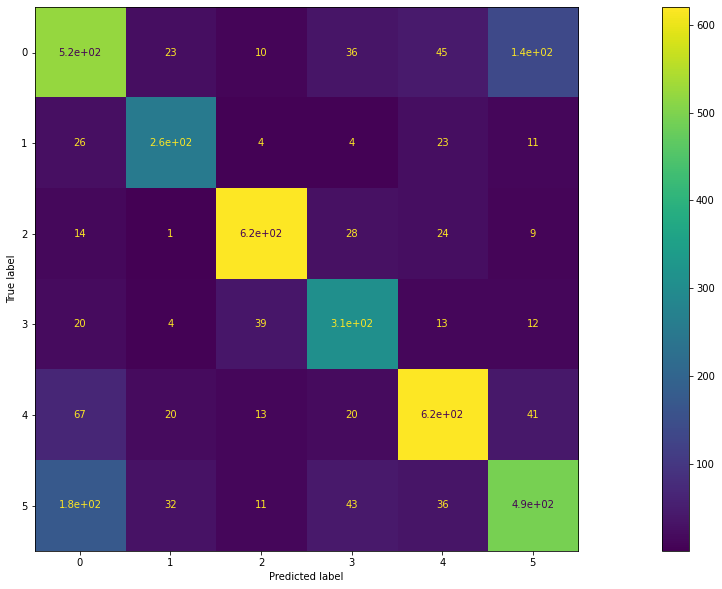

In [146]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.asarray([0,1,2,3,4,5]))


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(30, 10))
disp = disp.plot(ax=ax)
plt.show()

In [ ]:
x_test

array([[   0,    0,    0, ..., 7128, 3891, 4794],
       [   0,    0,    0, ..., 3963, 4900, 2805],
       [   0,    0,    0, ..., 4900, 5795, 6604],
       ...,
       [   0,    0,    0, ..., 1162, 4900, 7227],
       [   0,    0,    0, ..., 3083, 3505, 7516],
       [   0,    0,    0, ..., 4859, 4859, 5494]], dtype=int32)

#Emotion prediction

In [75]:
em = ["anger", "fear", "joy","love", "sadness", "surprise"]

In [149]:
def emotion_prediction(text, model):
  one_hot_rep = [one_hot(input_text=text, n=vocab_size)]
  embeddec_text = pad_sequences(one_hot_rep, maxlen=len_sentence, padding="pre")
  prediction = model.predict(embeddec_text)
  print(prediction)
  classe =np.argmax(prediction,axis=1)
  return em[classe[0]]

In [174]:
emotion_prediction("He's over the moon about being accepted to the university", model)

[[8.2407522e-01 1.6471377e-02 1.3372291e-02 1.6353491e-03 1.4370266e-01
  7.4303680e-04]]


'anger'